# Q3 - How do choices about data in a affect the performance of a neural network

We've looked at how well a neural network identifies exoplanets based on stellar features from the Kepler Exoplanetary Search Results dataset, and compared that to a traditional method such as random forest. Now, we will have a deeper look into the performance of a neural network, by varying the amount of training data and balance of classes to see how accuracy and processing times are affected.

**Before working through this notebook, ensure you have read through the [README.md](https://github.com/GHancock1/Coursework-2/blob/main/README.md) and installed the necessary Python dependencies.**

In [1]:
# Importing the same libraries as in Q2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import torch
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import sys
sys.path.append("..")
from functions import *

df = getData()
df = df.drop(columns=["rowid","kepid", "kepoi_name", "kepler_name"])
scaled_df = normalize(df)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
s_features = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad", "koi_smass"]
model_df = scaled_df.dropna(subset=s_features + ["koi_score"]).copy()
X = model_df[s_features]

Our usual setup is complete, so lets test the first variable we want to vary: the amount of training data. We will test a range of training / testing splits, between 10% and 90%, and see which split has the highest accuracy.

In [7]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # test sizes between 10% and 90%

epochs = 10
test_list = np.ndarray((len(sizes), 2))  # This will store test splits and accuracies
list_index = 0
y = (model_df["koi_score"] >= 0.5).astype(int) 

# Looping over our array of test sizes
for test_size in sizes:
    test_list[list_index, 0] = test_size

    X_train, X_test, y_train, y_test = split(X, y, test_size) # Split function is defined in functions.py
    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = tensors(X_train, X_test, y_train, y_test) # defined in functions.py
    train_loader, test_loader, train_df, test_df, pos_weight = load_data(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, device) # defined in functions.py

    model = MLP(input_dim=X_train.shape[1]).to(device)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model = training(epochs, train_loader, model,loss_func, optimizer, device)
    acc = testing(model, X_test_tensor, y_test_tensor, device)
    test_list[list_index, 1] = acc
    list_index += 1

# What split had the best accuracy?
best_split_index = np.argmax(test_list[:, 1])
best_split = test_list[best_split_index, 0]
best_acc = test_list[best_split_index, 1]
print(f"Best test size: {best_split}, with accuracy: {best_acc}")

Best test size: 0.5, with accuracy: 0.681351689612015


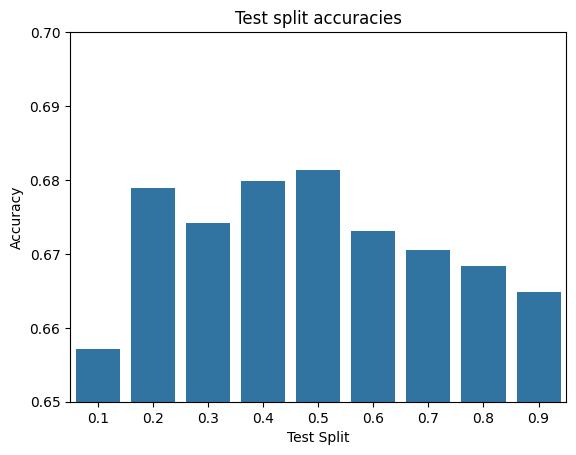

In [13]:
# plotting accuracy for each test size
plt.figure()
plt.ylim(0.65,0.7)
sns.barplot(x=test_list[:, 0], y=test_list[:, 1])
plt.xlabel("Test Split")
plt.ylabel("Accuracy")
plt.title("Test split accuracies")
plt.show()

In [ ]:
thresholds = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]

for threshold in thresholds:
    y = (model_df["koi_score"] >= threshold).astype(int)